# Import Libraries


In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess Dataset

In [5]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
0,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
1,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
3,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
4,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
4455,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
4456,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False
4457,2024-07-08 08:00:00,08:00:00,8,Monday,784.0,411.0,280.0,93.0,False,True,False,False,False,False,False,False


In [6]:
df['Time'] = pd.to_datetime(df['Time'])
df['TOD'] = df['Time'].dt.hour
df['office_day'] = ~df['Holiday']

# mapping dictionary
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}

# Map the day names to numerical values
df['Day'] = df['Day'].map(day_mapping)

df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,office_day
0,2024-01-04 15:00:00,15,15,5,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False,True
1,2024-01-04 16:00:00,16,16,5,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False,True
2,2024-01-04 17:00:00,17,17,5,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False,True
3,2024-01-04 18:00:00,18,18,5,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False,True
4,2024-01-04 19:00:00,19,19,5,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,2024-07-08 05:00:00,5,5,2,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False,True
4455,2024-07-08 06:00:00,6,6,2,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False,True
4456,2024-07-08 07:00:00,7,7,2,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False,True
4457,2024-07-08 08:00:00,8,8,2,784.0,411.0,280.0,93.0,False,True,False,False,False,False,False,False,True


In [7]:
df.index = df['Time']
df.head()

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,office_day
Time,,,,,,,,,,,,,,,,,
2024-01-04 15:00:00,2024-01-04 15:00:00,15,15,5,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False,True
2024-01-04 16:00:00,2024-01-04 16:00:00,16,16,5,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False,True
2024-01-04 17:00:00,2024-01-04 17:00:00,17,17,5,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False,True
2024-01-04 18:00:00,2024-01-04 18:00:00,18,18,5,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False,True
2024-01-04 19:00:00,2024-01-04 19:00:00,19,19,5,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False,True


In [8]:
# Keep the rows belonging to Sping season only (March, april, and May)
start_date = pd.to_datetime('2024-03-01')
end_date = pd.to_datetime('2024-06-01')

df_spring = df[(df['Time'] >= start_date) & (df['Time'] < end_date)]
df_spring

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,office_day
Time,,,,,,,,,,,,,,,,,
2024-03-01 00:00:00,2024-03-01 00:00:00,0,0,6,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False,True
2024-03-01 01:00:00,2024-03-01 01:00:00,1,1,6,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False,True
2024-03-01 02:00:00,2024-03-01 02:00:00,2,2,6,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False,True
2024-03-01 03:00:00,2024-03-01 03:00:00,3,3,6,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False,True
2024-03-01 04:00:00,2024-03-01 04:00:00,4,4,6,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,2024-05-31 19:00:00,19,19,6,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False,True
2024-05-31 20:00:00,2024-05-31 20:00:00,20,20,6,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False,True
2024-05-31 21:00:00,2024-05-31 21:00:00,21,21,6,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False,True


In [9]:
# df_holiday = df[df['Holiday'] == True]
df_holiday = df_spring[df_spring['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,office_day
Time,,,,,,,,,,,,,,,,,
2024-03-02 00:00:00,2024-03-02 00:00:00,0,0,7,755.0,187.0,384.0,184.0,False,False,True,False,False,False,False,True,False
2024-03-02 01:00:00,2024-03-02 01:00:00,1,1,7,620.0,232.0,203.0,185.0,False,False,True,False,False,False,False,True,False
2024-03-02 02:00:00,2024-03-02 02:00:00,2,2,7,800.0,307.0,309.0,184.0,False,False,True,False,False,False,False,True,False
2024-03-02 03:00:00,2024-03-02 03:00:00,3,3,7,801.0,418.0,199.0,184.0,False,False,True,False,False,False,False,True,False
2024-03-02 04:00:00,2024-03-02 04:00:00,4,4,7,710.0,330.0,196.0,184.0,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28 19:00:00,2024-05-28 19:00:00,19,19,3,1368.0,902.0,284.0,182.0,False,False,False,False,False,True,False,True,False
2024-05-28 20:00:00,2024-05-28 20:00:00,20,20,3,1533.0,1051.0,299.0,183.0,False,False,False,False,False,True,False,True,False
2024-05-28 21:00:00,2024-05-28 21:00:00,21,21,3,899.0,395.0,321.0,183.0,False,False,False,False,False,True,False,True,False


In [10]:
# df_office_day = df[df['Holiday'] == False]
df_office_day = df_spring[df_spring['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,office_day
Time,,,,,,,,,,,,,,,,,
2024-03-01 00:00:00,2024-03-01 00:00:00,0,0,6,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False,True
2024-03-01 01:00:00,2024-03-01 01:00:00,1,1,6,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False,True
2024-03-01 02:00:00,2024-03-01 02:00:00,2,2,6,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False,True
2024-03-01 03:00:00,2024-03-01 03:00:00,3,3,6,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False,True
2024-03-01 04:00:00,2024-03-01 04:00:00,4,4,6,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,2024-05-31 19:00:00,19,19,6,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False,True
2024-05-31 20:00:00,2024-05-31 20:00:00,20,20,6,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False,True
2024-05-31 21:00:00,2024-05-31 21:00:00,21,21,6,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False,True


**Drop unnecessary Columns**\
Since we are going to forecast the total load, loads of phase A, B, and C, are not required. Similarly, since we have already extracted the hour from time, the 'Time' column is not required anymore. Holidays and office days have already been separated. So, these information are also not required

In [11]:
df_office_day.drop(['Time', 'Phase_A (W)', 'Phase_B (W)', 'Phase_C (W)'], axis=1, inplace=True)
df_office_day.drop(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], axis=1, inplace=True)
df_office_day.drop(['Holiday', 'office_day', 'TOD'], axis=1, inplace=True)
df_office_day

<ipython-input-11-94374da283f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_office_day.drop(['Time', 'Phase_A (W)', 'Phase_B (W)', 'Phase_C (W)'], axis=1, inplace=True)
<ipython-input-11-94374da283f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_office_day.drop(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], axis=1, inplace=True)
<ipython-input-11-94374da283f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,Hour,Day,Total (W)
Time,,,
2024-03-01 00:00:00,0,6,792.0
2024-03-01 01:00:00,1,6,733.0
2024-03-01 02:00:00,2,6,706.0
2024-03-01 03:00:00,3,6,684.0
2024-03-01 04:00:00,4,6,784.0
...,...,...,...
2024-05-31 19:00:00,19,6,1070.0
2024-05-31 20:00:00,20,6,689.0
2024-05-31 21:00:00,21,6,718.0


**Scale the Numerical Attributes**

In [12]:
columns_to_scale = ['Hour', 'Day', 'Total (W)']
scaler = MinMaxScaler(feature_range=(-1, 1))
df_office_day[columns_to_scale] = scaler.fit_transform(df_office_day[columns_to_scale])

df_office_day

<ipython-input-12-9a5b84616b26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_office_day[columns_to_scale] = scaler.fit_transform(df_office_day[columns_to_scale])


,Hour,Day,Total (W)
Time,,,
2024-03-01 00:00:00,-1.000000,1.0,-0.869397
2024-03-01 01:00:00,-0.913043,1.0,-0.887700
2024-03-01 02:00:00,-0.826087,1.0,-0.896076
2024-03-01 03:00:00,-0.739130,1.0,-0.902901
2024-03-01 04:00:00,-0.652174,1.0,-0.871878
...,...,...,...
2024-05-31 19:00:00,0.652174,1.0,-0.783155
2024-05-31 20:00:00,0.739130,1.0,-0.901349
2024-05-31 21:00:00,0.826087,1.0,-0.892353


In [13]:
df_office_day.shape

(1728, 3)

# **Separate train and test data**

In [14]:
training_data_len = int(len(df_office_day)*0.6)
validation_data_len = int(len(df_office_day)*0.2)
print(training_data_len)
print(validation_data_len)

train_data = df_office_day[:training_data_len]
validation_data = df_office_day[training_data_len:training_data_len+validation_data_len]
test_data = df_office_day[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

1036
345
(1036, 3) (345, 3) (347, 3)


In [15]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1, 3))
dataset_train.shape

(1036, 3)

In [16]:
dataset_validation = validation_data.values
dataset_validation = np.reshape(dataset_validation, (-1, 3))
dataset_validation.shape

(345, 3)

In [17]:
dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1, 3))
dataset_test.shape

(347, 3)

**Create Sequences**

In [18]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [19]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])


X_train, y_train = np.array(X_train), np.array(y_train)
y_train = y_train[:, :, -1].reshape(-1, 24, 1)

X_train.shape, y_train.shape

((1012, 24, 3), (1012, 24, 1))

In [20]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)
y_validation = y_validation[:, :, -1].reshape(-1, 24, 1)

X_validation.shape, y_validation.shape

((321, 24, 3), (321, 24, 1))

In [21]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)
y_test = y_test[:, :, -1].reshape(-1, 24, 1)

X_test.shape, y_test.shape

((323, 24, 3), (323, 24, 1))

**Convert To Tensors**

In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([1012, 24, 3]) torch.Size([1012, 24, 1])
torch.Size([321, 24, 3]) torch.Size([321, 24, 1])
torch.Size([323, 24, 3]) torch.Size([323, 24, 1])


# Create Model

In [45]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, drop_out=0.0):
    super(GRU, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=drop_out)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out)
    return out

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [47]:
input_size = 3
num_layers = 2
hidden_size = 97
output_size = 1
drop_out = 0.08634
learning_rate = 0.00093722

model = GRU(input_size, hidden_size, num_layers, drop_out).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(model)

GRU(
  (gru): GRU(3, 97, num_layers=2, batch_first=True, dropout=0.08634)
  (fc): Linear(in_features=97, out_features=1, bias=True)
)


**Torch DataLoader**

In [48]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [49]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 24, 3]), y shape: torch.Size([32, 24, 1])


# Train the Model

In [50]:
num_epochs = 48
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# predictions = predictions[:, -1, :]
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation).to(device)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


Epoch [10/48] - Training Loss: 0.0317, Validation Loss: 0.0661
Epoch [20/48] - Training Loss: 0.0282, Validation Loss: 0.0630
Epoch [30/48] - Training Loss: 0.0261, Validation Loss: 0.0591
Epoch [40/48] - Training Loss: 0.0240, Validation Loss: 0.0597


In [51]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Validation MAPE: {validation_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 27.47, Validation MAPE: 41.03
Epoch 20 - Training MAPE: 26.55, Validation MAPE: 40.87
Epoch 30 - Training MAPE: 25.68, Validation MAPE: 40.84
Epoch 40 - Training MAPE: 24.34, Validation MAPE: 43.81


In [52]:
print(f'Training MAPE: {train_mape_hist[-1]:.2f}, Validation MAPE: {validation_mape_hist[-1]:.2f}')

Training MAPE: 23.55, Validation MAPE: 42.76


In [53]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

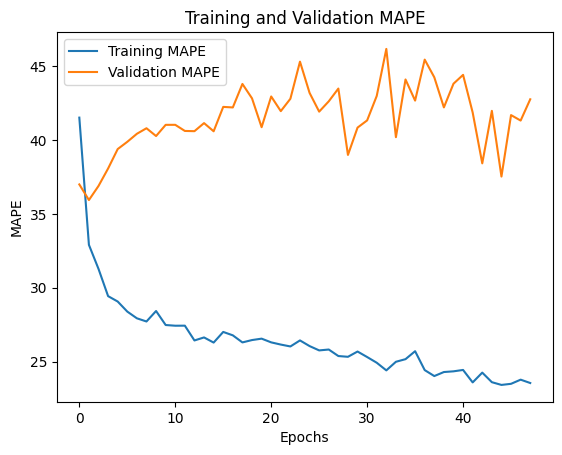

In [54]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.title("Training and Validation MAPE")
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.legend()
plt.show()

# Evaluate on Test Data

In [55]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions = model(batch_X_test)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])



In [56]:
# MAPE on test data
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on test data = 38.46


In [57]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test = np.repeat(actuals_test, 3, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)
actuals_test_original = actuals_test_original[:, 2]

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test = np.repeat(predictions_test, 3, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)
predictions_test_original = predictions_test_original[:, 2]

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

,Predicted Power,Actual Power
0,1854.922588,3360.999992
1,1995.886309,1770.000010
2,1594.789276,1062.000023
3,1146.522383,729.000064
4,1033.265764,1268.999972
...,...,...
318,1160.026824,1069.999972
319,1240.727799,688.999935
320,1197.512282,717.999918
321,1174.881593,606.000058


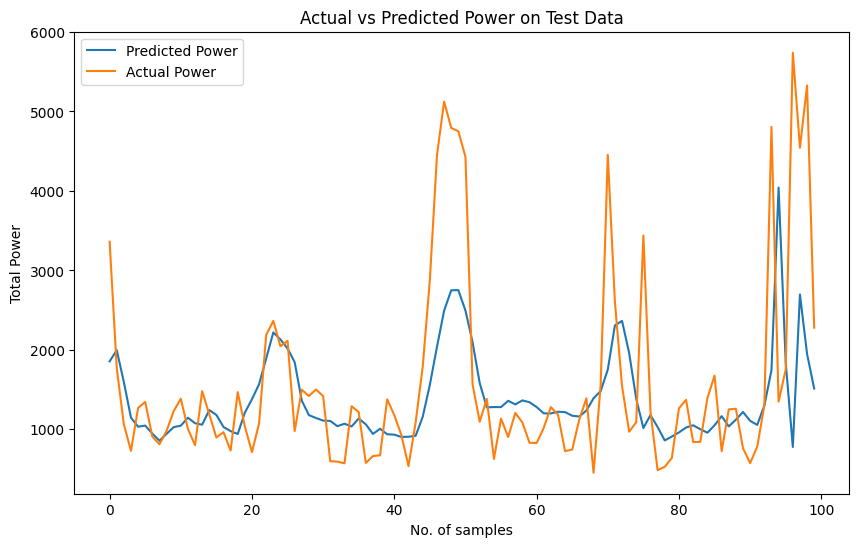

In [58]:
# plot actual vs predicted powers on first test data
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_original[:100], label='Predicted Power')
plt.plot(actuals_test_original[:100], label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Training Data

In [59]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])



In [60]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on train data = 22.77


In [61]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train = np.repeat(actuals_train, 3, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)
actuals_train_original = actuals_train_original[:, 2]

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train = np.repeat(predictions_train, 3, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)
predictions_train_original = predictions_train_original[:, 2]

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})


,Predicted Power,Actual Power
0,814.534594,545.000088
1,1070.012845,838.999985
2,1315.373430,858.999953
3,961.749446,607.999997
4,998.235607,697.000076
...,...,...
1007,1453.749469,1230.999975
1008,939.767215,785.999963
1009,1427.189416,867.999967
1010,936.686321,872.000038


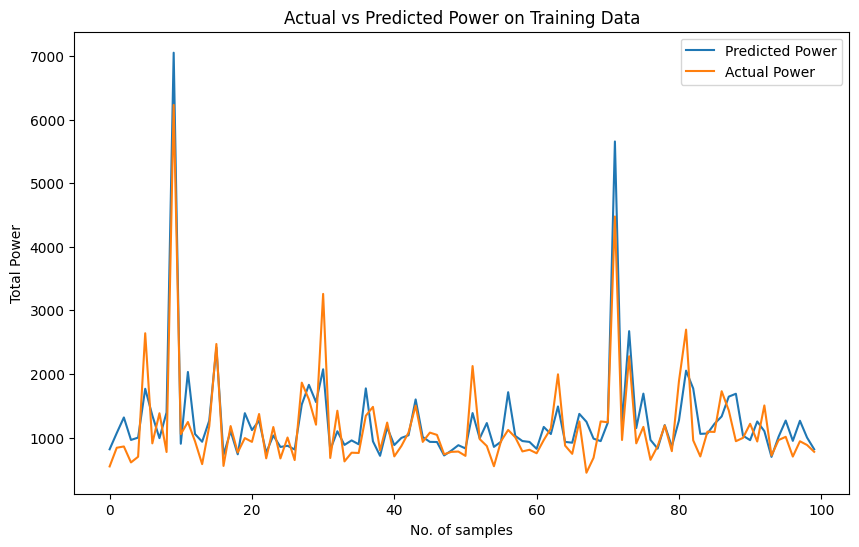

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_train_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_train_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Validations Data

In [63]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy()[:, :]
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy()[:, :]
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [64]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on validation data = 30.77


In [65]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation = np.repeat(actuals_validation, 3, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)
actuals_validation_original = actuals_validation_original[:, 2]

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation = np.repeat(predictions_validation, 3, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)
predictions_validation_original = predictions_validation_original[:, 2]

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

,Predicted Power,Actual Power
0,1064.130423,676.000043
1,953.989858,668.000094
2,897.843233,875.999916
3,925.328995,1062.000023
4,1017.712005,1194.000044
...,...,...
316,835.809573,1461.000089
317,1440.516708,1236.999985
318,2038.031055,4153.000018
319,4497.722217,6231.000080


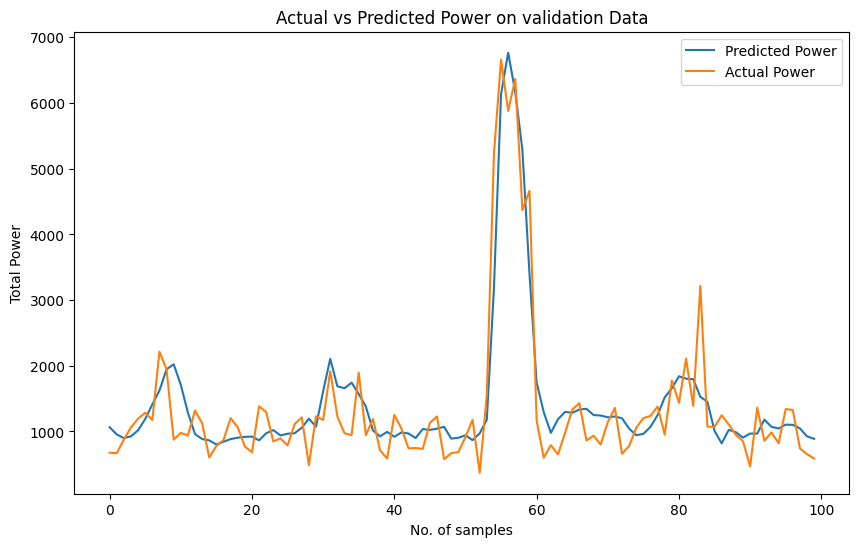

In [66]:
# plot on first 100 validation data
plt.figure(figsize=(10, 6))
plt.plot(predictions_validation_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_validation_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()